# Setup

In [1]:
import os
from typing import Collection
import numpy as np
from matplotlib import pyplot as plt

from pdkmaster.design import library as _lbry

from c4m.pdk import sky130
prims = sky130.tech.primitives

# Contrary to the PySpice v1.5 release notes my simulations with own compiled ngspice-34
# fail to run. Use v33 of the library. This can be commented if a supported ngspice shared
# is in the lib search path.
home = os.environ["HOME"]
os.environ["NGSPICE_LIBRARY_PATH"]=f"{home}/software/mint20/stow/ngspice-33/lib/libngspice.so.0"

# IO n/p ratio

Determine the w ratio needed for the IO nmos/pmos transistors to get equal drive strength on the transistor

corner: tt
corner: ss
corner: ff
corner: fs
corner: sf


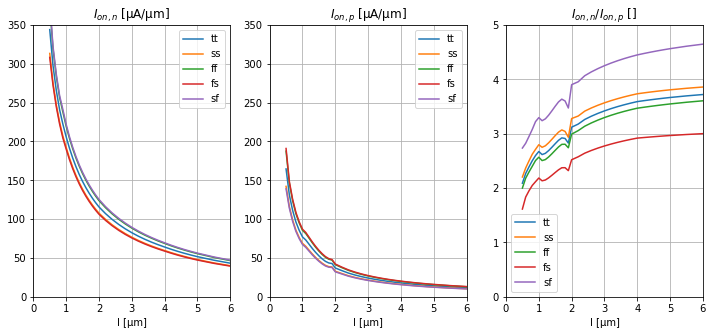

In [32]:
ion = None
def _block():
    global ion

    def sim_ion(*, ls: Collection[float], corner: str):
        # Make one circuit with transistor for all ls
        # This avoids the startup time when one would do the simulation separately
        ckt = sky130.cktfab.new_circuit(name="ion_tb")

        iovss = ckt.new_net("iovss", external=True)
        for i, l in enumerate(ls):
            # Simulate 10µm IO nmos transistor on current
            ionmos = ckt.new_instance(name=f"nmos_{i}", object_=prims.nfet_g5v0d10v5, l=l, w=10.0)
            iopmos = ckt.new_instance(name=f"pmos_{i}", object_=prims.pfet_g5v0d10v5, l=l, w=10.0)

            iovss.childports += (
                ionmos.ports.sourcedrain1, ionmos.ports.bulk,
                iopmos.ports.sourcedrain1, iopmos.ports.gate,
            )
            ckt.new_net(name=f"iovdd_n_{i}", external=True, childports=(
                ionmos.ports.sourcedrain2, ionmos.ports.gate,
            ))
            ckt.new_net(name=f"iovdd_p_{i}", external=True, childports=(
                iopmos.ports.sourcedrain2, iopmos.ports.bulk,
            ))

        tb = sky130.pyspicefab.new_pyspicecircuit(corner=corner, top=ckt, title="Ion")
        tb.V("gnd", "iovss", tb.gnd, 0.0)
        for i in range(len(ls)):
            tb.V(f"vdd_n_{i}", f"iovdd_n_{i}", tb.gnd, 3.3)
            tb.V(f"vdd_p_{i}", f"iovdd_p_{i}", tb.gnd, 3.3)

        sim = tb.simulator(temperature=25)
        op = sim.operating_point()

        ion = np.ndarray([2, len(ls)])
        for i in range(len(ls)):
            ion[0, i] = -getattr(op, f"vvdd_n_{i}")[0].value
            ion[1, i] = -getattr(op, f"vvdd_p_{i}")[0].value
        return ion

    ls = (*np.arange(0.5, 2.01, 0.1), *np.arange(2.2, 5.01, 0.2), *(5.5, 6.0))
    corners = ("tt", "ss", "ff", "fs", "sf")

    ion = np.ndarray([2, len(ls), len(corners)])
    for i, corner in enumerate(corners):
        print(f"corner: {corner}")
        ion[:, :, i] = sim_ion(ls=ls, corner=corner)
    
    plt.figure(figsize=(12.0, 5.0))

    plt.subplot(1, 3, 1)
    plt.plot(ls, 1e6*(ion[0,:,:]/10))
    plt.axis([0, 6, 0, 350])
    plt.xlabel("l [µm]")
    plt.title("$I_{on,n}$ [µA/µm]")
    plt.legend(corners)
    plt.grid()
    
    plt.subplot(1, 3, 2)
    plt.plot(ls, 1e6*(ion[1,:,:]/10))
    plt.axis([0, 6, 0, 350])
    plt.xlabel("l [µm]")
    plt.title("$I_{on,p}$ [µA/µm]")
    plt.legend(corners)
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(ls, ion[0, :, :]/ion[1, :, :])
    plt.axis([0, 6, 0, 5])
    plt.xlabel("l [µm]")
    plt.title("$I_{on,n}$/$I_{on,p}$ []")
    plt.legend(corners)
    plt.grid()
_block()

# LevelUp verification

In [42]:
def _block():
    lu = sky130.iolib.cells.LevelUp
    tb = sky130.pyspicefab.new_pyspicecircuit(corner="tt", top=lu.circuit, title="LevelUp")
    tb.V("vss", "vss", tb.gnd, 0.0)
    tb.V("iovss", "iovss", tb.gnd, 0.0)
    tb.V("vdd", "vdd", tb.gnd, 1.8)
    tb.V("iovdd", "iovdd", tb.gnd, 3.3)
    tb.PieceWiseLinearVoltageSource("in_", "i", tb.gnd, values=((0, 0), (1, 1.8), (2, 0)))

    sim = tb.simulator(temperature=25)
    trans = sim.transient(step_time=1e-3, end_time=2)

    plt.plot(trans.i, trans.o)
    plt.axis((0, 1.8, 0, 3.35))
    plt.grid()
    plt.xlabel("i [V]")
    plt.ylabel("o [V]")
_block()

# LevelDown verification

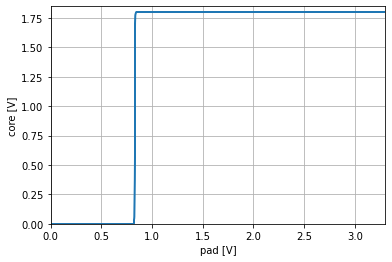

In [2]:
def _block():
    ld = sky130.iolib.cells.LevelDown
    tb = sky130.pyspicefab.new_pyspicecircuit(corner="tt", top=ld.circuit, title="LevelDown")
    tb.V("vss", "vss", tb.gnd, 0.0)
    tb.V("iovss", "iovss", tb.gnd, 0.0)
    tb.V("vdd", "vdd", tb.gnd, 1.8)
    tb.V("iovdd", "iovdd", tb.gnd, 3.3)
    tb.PieceWiseLinearVoltageSource("in_", "pad", tb.gnd, values=((0, 0), (1, 3.3), (2, 0)))

    sim = tb.simulator(temperature=25)
    trans = sim.transient(step_time=1e-3, end_time=2)

    plt.plot(trans.pad, trans.core)
    plt.axis((0, 3.3, 0, 1.85))
    plt.grid()
    plt.xlabel("pad [V]")
    plt.ylabel("core [V]")
_block()

# IOPadInOut verification

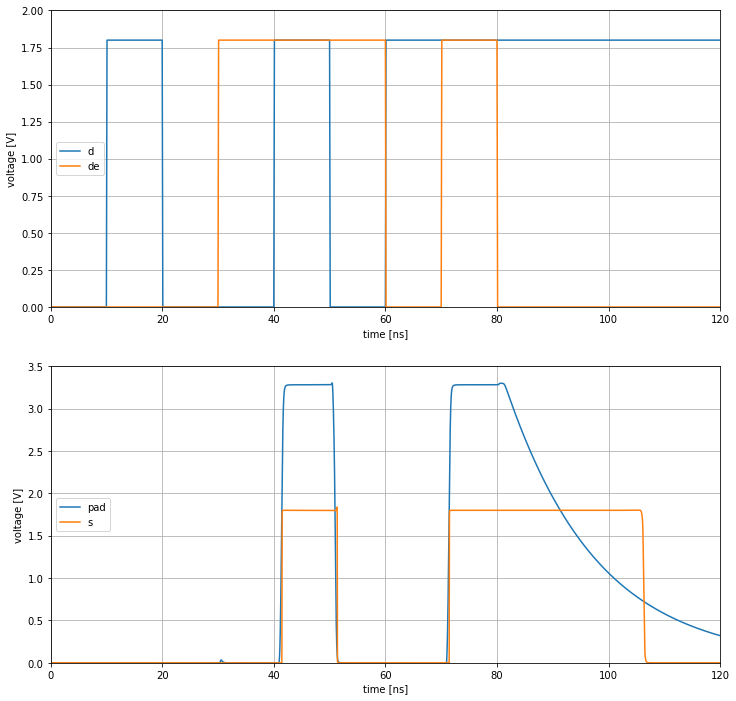

In [22]:
def _block():
    inout = sky130.iolib.cells.IOPadInOut
    tb = sky130.pyspicefab.new_pyspicecircuit(corner="tt", top=inout.circuit, title="GPIO")
    tb.V("vss", "vss", tb.gnd, 0.0)
    tb.V("iovss", "iovss", tb.gnd, 0.0)
    tb.V("vdd", "vdd", tb.gnd, 1.8)
    tb.V("iovdd", "iovdd", tb.gnd, 3.3)
    tb.C("load", "pad", tb.gnd, 1e-12)
    tb.R("load", "pad", tb.gnd, 1e4)

    t_trans = 0.1e-9
    tb.PieceWiseLinearVoltageSource("d", "d", tb.gnd, values=(
        (0, 0), (10e-9, 0), (10e-9 + t_trans, 1.8), (20e-9, 1.8), (20e-9 + t_trans, 0),
        (40e-9, 0), (40e-9 + t_trans, 1.8), (50e-9, 1.8), (50e-9 + t_trans, 0), (60e-9, 0),
        (60e-9 + t_trans, 1.8), (90e-9, 1.8),
    ))
    tb.PieceWiseLinearVoltageSource("de", "de", tb.gnd, values=(
        (0, 0), (30e-9, 0),
        (30e-9 + t_trans, 1.8), (60e-9, 1.8),
        (60e-9 + t_trans, 0), (70e-9, 0), (70e-9 + t_trans, 1.8), (80e-9, 1.8), (80e-9 + t_trans, 0),
    ))

    sim = tb.simulator(temperature=25)
    trans = sim.transient(step_time=0.01e-9, end_time=120e-9)

    time = np.array(trans.time)*1e9

    plt.figure(figsize=[12,12])

    plt.subplot(2,1,1)
    plt.plot(time, trans.d, time, trans.de)
    plt.axis((time[0], time[-1], 0, 2.0))
    plt.legend(("d", "de"), loc="center left")
    plt.xlabel("time [ns]")
    plt.ylabel("voltage [V]")
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(time, trans.pad, time, trans.s)
    plt.axis((time[0], time[-1], 0, 3.50))
    plt.legend(("pad", "s"), loc="center left")
    plt.xlabel("time [ns]")
    plt.ylabel("voltage [V]")
    plt.grid()

_block()